In [1]:
import sys 
sys.path.append('..')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import date
from numpy import trapz

In [3]:
min_temp = pd.read_excel('../input/MinClimate.xlsx', sheet_name='Temp')
min_prec = pd.read_excel('../input/MinClimate.xlsx', sheet_name='Prec')
a_classified = pd.read_excel('../input/quotient_deviation_df_A_CLASSIFIED.xlsx')
b_classified = pd.read_excel('../input/quotient_deviation_df_B_CLASSIFIED_FIXED.xlsx')

In [4]:
monthly_temp = pd.DataFrame({'Year':list(min_temp.columns[2:])})
monthly_prec = pd.DataFrame({'Year':list(min_prec.columns[2:])})

months_names = ['', 'January', 'February', 'March',
                'April', 'May', 'June', 'July',
                'August', 'September', 'October',
                'November', 'December']

for i in range(1,13):
    monthly_temp[months_names[i]] = list(min_temp[min_temp['Month']==i].mean(skipna=True)[2:])
    monthly_prec[months_names[i]] = list(min_prec[min_prec['Month']==i].sum(skipna=True)[2:])

In [5]:
from utils.functions import get_moving_avg, get_moving_sum, list_to_cumulative

In [6]:
first_day = 91 +30 #, +44, +61
last_day = -61 -31

In [22]:
mean_prec.mean(axis=1)

121      0.824370
122      1.645798
123      2.452941
124      3.273950
125      4.156723
          ...    
269    261.149160
270    262.260924
271    263.292857
272    264.179412
273    265.028151
Length: 153, dtype: float64

C:\Users\8FEE~1\AppData\Local\Temp/ipykernel_15496/624104638.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  date_df['Year'] = [2000 for _ in range(len(date_df))]


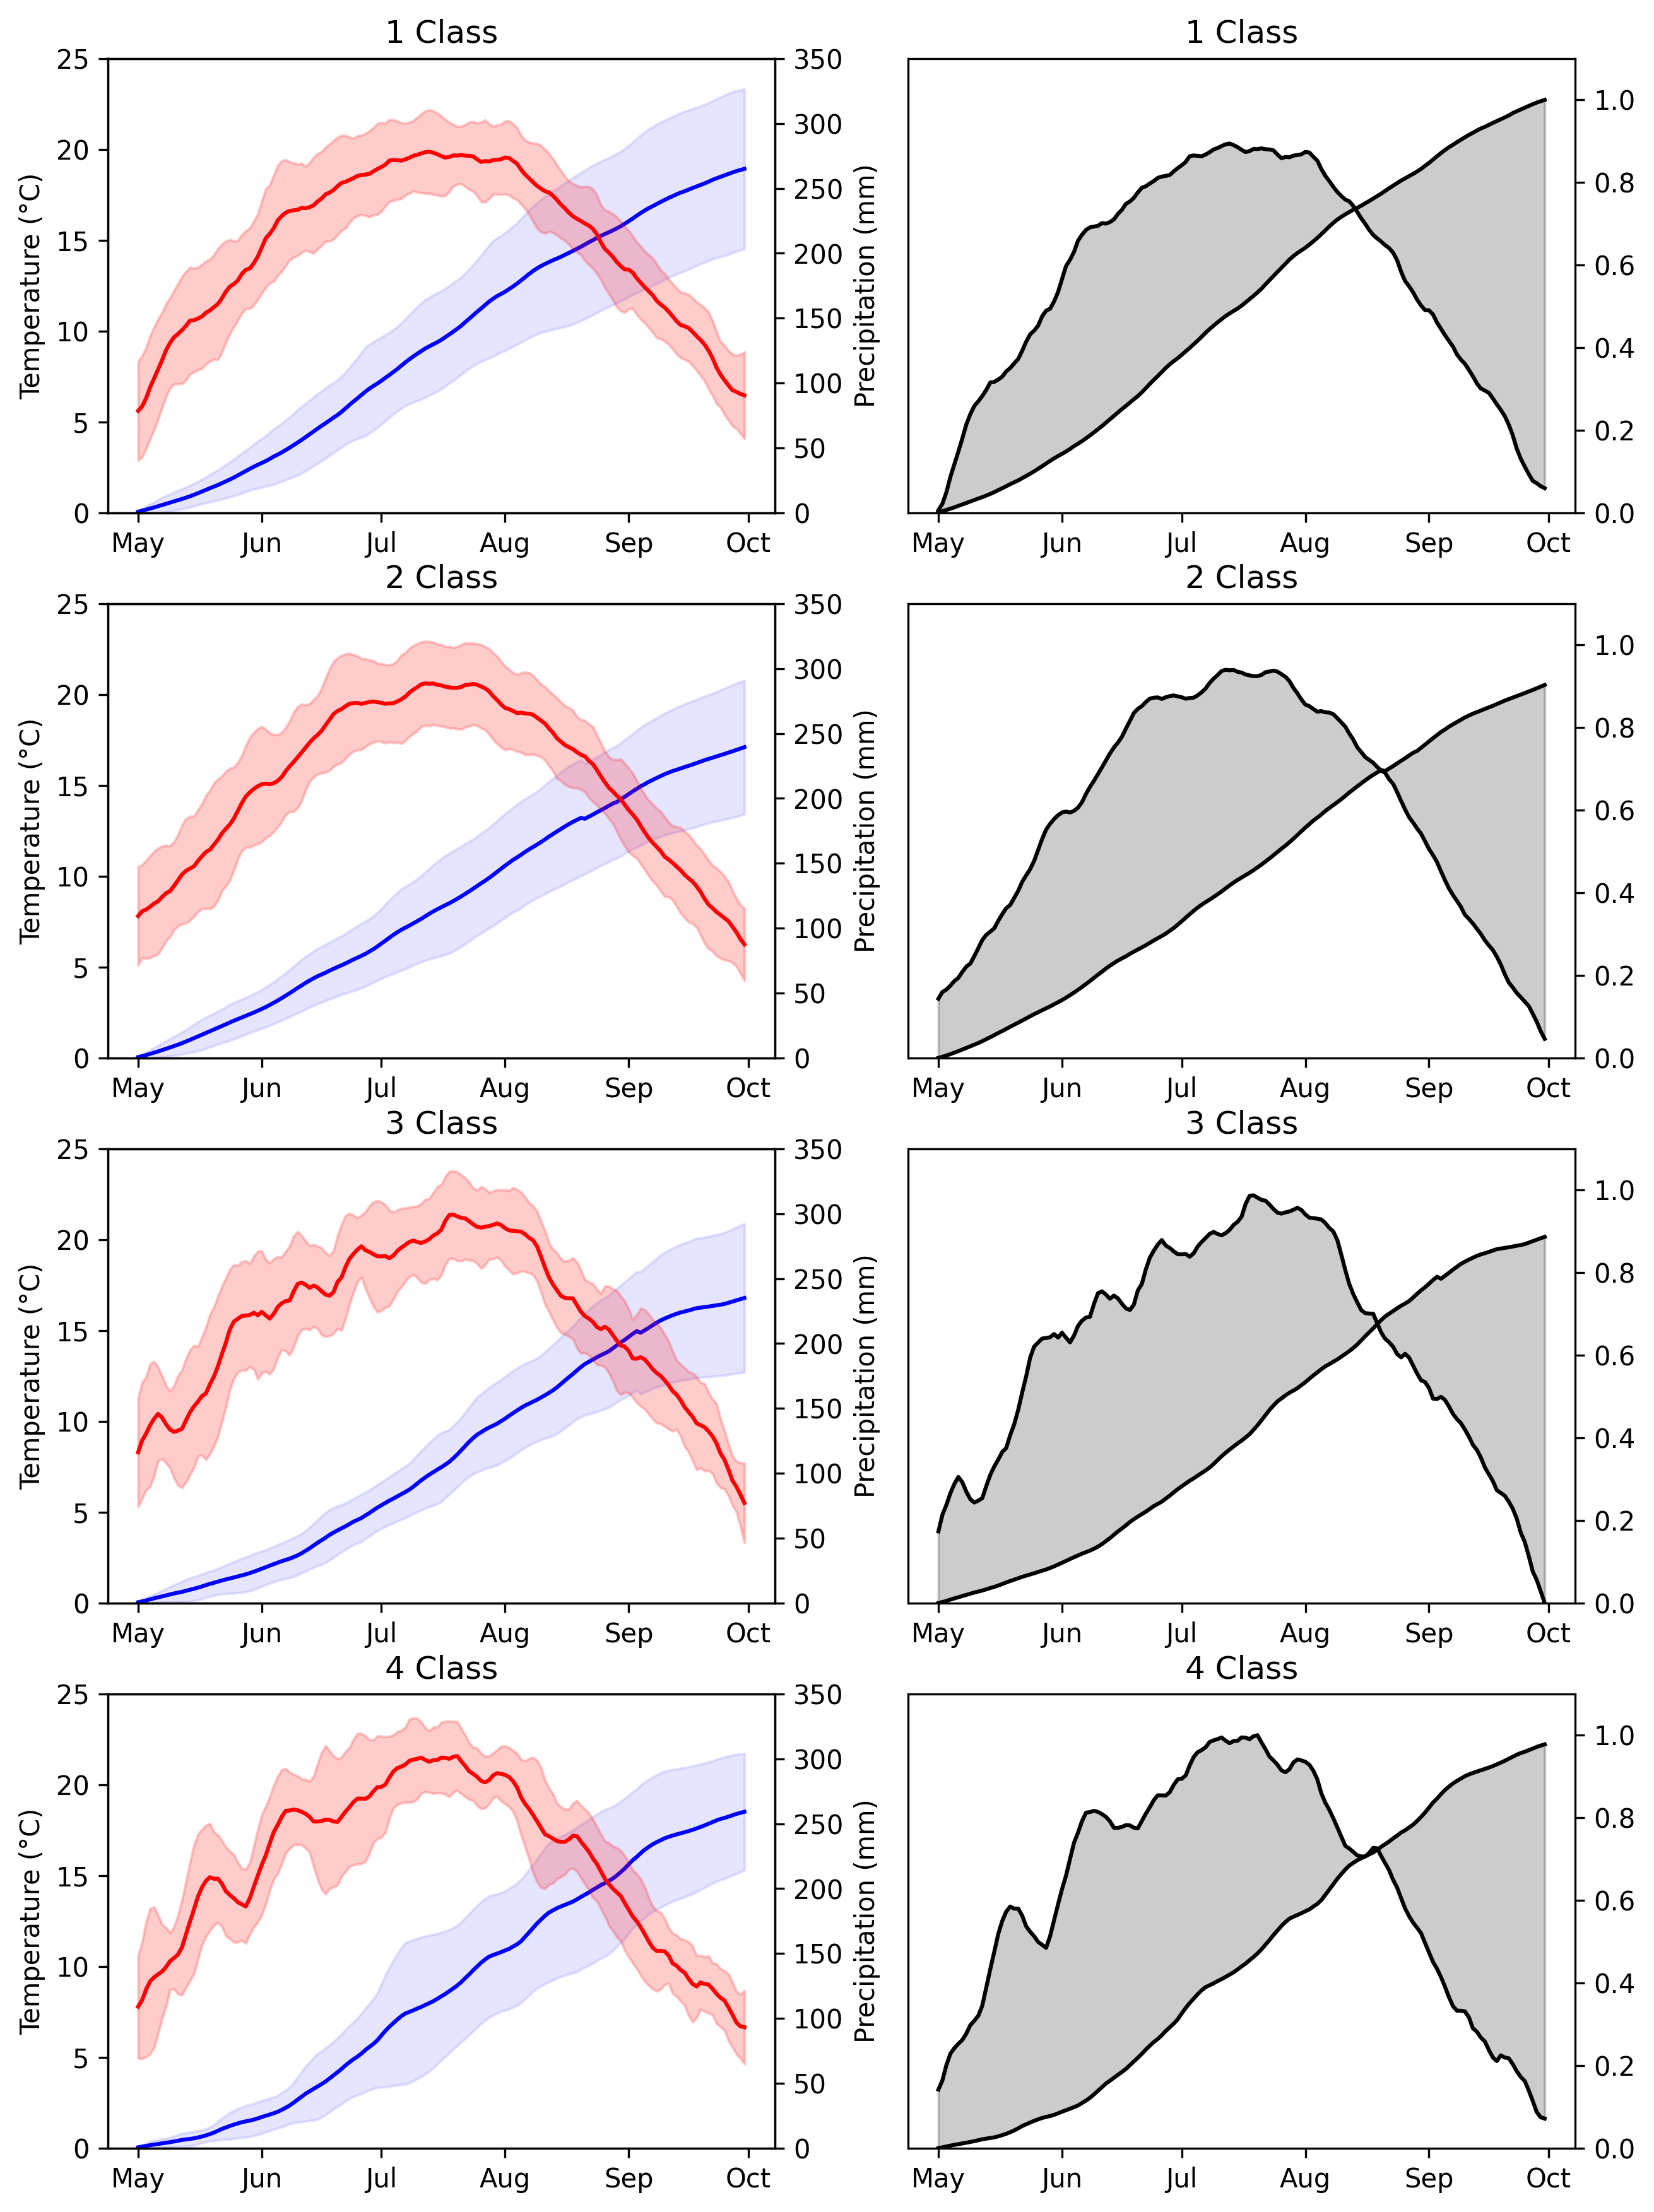

In [10]:
date_df = min_temp[['Month', 'Day']]
date_df['Year'] = [2000 for _ in range(len(date_df))]
x = pd.to_datetime(date_df)[first_day:last_day]

mean_temps = []
mean_precs = []

fig, ax = plt.subplots(nrows=4, ncols=2, dpi=300, figsize=(10, 12))
plt.subplots_adjust(bottom=0.03, top=0.95)


for i in range(4):
    mean_temp = get_moving_avg(min_temp)[[year for year in a_classified[a_classified['Class 4']==i]['Year'] if year in min_temp.columns]]
    y = mean_temp.mean(axis=1)[first_day:last_day]
    mean_temps += [y]
    dy = mean_temp.std(axis=1)[first_day:last_day]

    ax[i, 0].fill_between(x, y-dy, y+dy, color='red', alpha=0.2)
    ax[i, 0].plot(x, y, c='red')

    mean_prec = get_moving_avg(min_prec)[[year for year in a_classified[a_classified['Class 4']==i]['Year'] if year in min_prec.columns]]
    mean_prec = mean_prec.iloc[first_day:last_day].cumsum()
    y = mean_prec.mean(axis=1)
    mean_precs += [y]
    dy = mean_prec.std(axis=1)
    
    ax2 = ax[i, 0].twinx()
    ax2.plot(x, y, color='blue')
    ax2.fill_between(x, y-dy, y+dy, color='blue', alpha=0.1)

    ax2.set_ylim([0, 350])
    
    ax[i, 0].set_ylabel('Temperature (°C)')
    ax2.set_ylabel('Precipitation (mm)')
    ax[i, 0].set_zorder(1)  # default zorder is 0 for ax1 and ax2
    ax[i, 0].patch.set_visible(False)  # prevents ax1 from hiding ax2

    locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
    formatter = mdates.ConciseDateFormatter(locator)
    ax[i, 0].xaxis.set_major_locator(locator)
    ax[i, 0].xaxis.set_major_formatter(formatter)
    locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
    formatter = mdates.ConciseDateFormatter(locator)
    ax[i, 1].xaxis.set_major_locator(locator)
    ax[i, 1].xaxis.set_major_formatter(formatter)
    #ax.set_xlim([date(2000, 4, 1), date(2000, 10, 30)])
    ax[i, 0].set_ylim([0, 25])
    ax[i, 1].set_ylim([0, 1.1])

    selected = a_classified[a_classified['Class 4']==i]
    temp_to_plot = monthly_temp.loc[monthly_temp['Year'].isin(list(selected['Year']))]
    

    ax[i, 0].set_title(f'{i+1} Class')
    ax[i, 1].set_title(f'{i+1} Class')
    ax[i, 1].yaxis.tick_right()
    #plt.savefig(f'../output/{i+1} Class (d&cwt)', dpi=300)

temp_max = max([max(el) for el in mean_temps])
prec_max = max([max(el) for el in mean_precs])
temp_min = min([min(el) for el in mean_temps])
prec_min = min([min(el) for el in mean_precs])

scaled_mean_temps = [(np.array(el) - temp_min) / (temp_max - temp_min) for el in mean_temps]
scaled_mean_precs =  [(np.array(el) - prec_min) / (prec_max - prec_min) for el in mean_precs]

i = 0
for el in scaled_mean_temps:
    ax[i, 1].plot(x, el, color='black', label=f'Class {i+1}')
    i += 1
i = 0
for el in scaled_mean_precs:
    ax[i, 1].plot(x, el, color='black')
    i += 1

i=0
for el1, el2 in zip(scaled_mean_temps, scaled_mean_precs):
    index = el2 < el1
    
    ax[i, 1].fill_between(x, el1, el2, color='black', alpha=0.2)
    #ax[i, 1].fill_between(x.iloc[np.arange(0, len(el1[index]))], el1[index], el2[index], color='black', alpha=0.2)
    i+=1

#plt.savefig('../output/Fig 6.png', dpi=300)
plt.show()
plt.close(fig)

In [13]:
np.array([-1,1])+np.array([-1,1])

array([-2,  2])

In [13]:
def find_area_between_temp_prec(temp: np.array, prec: np.array, trapz_rule=True):
    if len(temp) != len(prec):
        raise Exception('Arrays are not the same length!')
    index = prec < temp
    if trapz_rule:
        return trapz(temp[index]) - trapz(prec[index])
    else:
        return sum(abs(temp[index] - prec[index]))

In [28]:
i = 1
for temp, prec in zip(scaled_mean_temps, scaled_mean_precs):
    print('Class', i, ':', find_area_between_temp_prec(temp, prec))
    i += 1

Class 1 : 52.7570713306728
Class 2 : 61.64547924899232
Class 3 : 67.34603209200708
Class 4 : 65.82822902367121


# Area calulating for every year

In [14]:
first_day = 91 +30 # +14  +44 +61 
last_day = -61 -31

In [15]:
temp_df = get_moving_avg(min_temp)[first_day:last_day].reset_index(drop=True)

scaled_temp_df = (temp_df - min(temp_df.min()[2:])) / (max(temp_df.max()[2:]) - min(temp_df.min()[2:]))
scaled_temp_df['Month'] = temp_df['Month']
scaled_temp_df['Day'] = temp_df['Day']

In [17]:
cum_prec = {
    'Month': list(min_prec['Month']),
    'Day': list(min_prec['Day'])
}
for column in min_prec.columns:
    if column in ['Day', 'Month']:
        continue
    cum_prec[column] = list_to_cumulative(min_prec[column])
cum_prec = pd.DataFrame(cum_prec)

In [18]:
prec_df = get_moving_avg(cum_prec)[first_day:last_day].reset_index(drop=True)
scaled_prec_df = (prec_df - min(prec_df.min()[2:])) / (max(prec_df.max()[2:]) - min(prec_df.min()[2:]))
scaled_prec_df['Month'] = prec_df['Month']
scaled_prec_df['Day'] = prec_df['Day']

In [23]:
scaled_temp_df

,Month,Day,1915,1916,1917,1918,1919,1920,1921,1922,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,5,1,0.573370,0.177019,0.338509,0.359213,0.337474,0.285197,0.312629,0.232919,...,0.223602,0.432712,0.366977,0.252588,0.383540,0.430124,0.286749,0.253623,0.282609,0.271739
1,5,2,0.517391,0.199793,0.339027,0.407867,0.308489,0.261387,0.330228,0.249482,...,0.212733,0.420290,0.302277,0.251035,0.446687,0.420807,0.309524,0.245859,0.280538,0.254658
2,5,3,0.483092,0.218944,0.327122,0.462733,0.276398,0.231884,0.319876,0.231884,...,0.220497,0.399586,0.248447,0.252588,0.495342,0.397516,0.336957,0.247412,0.282609,0.267598
3,5,4,0.486542,0.220497,0.344720,0.460145,0.213768,0.209110,0.305901,0.223085,...,0.241718,0.396480,0.223085,0.259834,0.498447,0.358696,0.325569,0.273292,0.306936,0.296584
4,5,5,0.475673,0.202381,0.357143,0.442547,0.138199,0.180124,0.276398,0.217909,...,0.279503,0.358696,0.213768,0.255176,0.469979,0.376812,0.326605,0.290373,0.326087,0.347826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,9,26,0.340580,0.283644,0.354555,0.342650,0.190994,0.312629,0.340062,0.198240,...,0.268634,0.371636,0.339545,0.332298,0.329710,0.290890,0.167702,0.175466,0.252070,NaN
149,9,27,0.284679,0.245342,0.355590,0.344720,0.206522,0.331263,0.317288,0.200311,...,0.264493,0.361284,0.346791,0.287267,0.336439,0.316770,0.197205,0.177019,0.226708,NaN
150,9,28,0.231884,0.231884,0.370600,0.303313,0.211698,0.305901,0.302277,0.233437,...,0.248447,0.363354,0.366977,0.273292,0.324534,0.320393,0.210145,0.194099,0.189959,NaN
151,9,29,0.189441,0.238095,0.373706,0.307971,0.234472,0.268634,0.298137,0.274845,...,0.225673,0.360248,0.387681,0.242236,0.310041,0.301760,0.220497,0.250000,0.162008,NaN


In [14]:
areas = []

for column in scaled_prec_df.columns:
    if column in ['Day', 'Month']:
        continue
    a = find_area_between_temp_prec(scaled_temp_df[column], scaled_prec_df[column], False)
    areas += [ a if a != 0 else np.nan]

----------------

In [15]:
areas_df = {'Year': scaled_prec_df.columns[2:], 'Area':areas}

In [91]:
areas_df['Area May_1st'] = areas

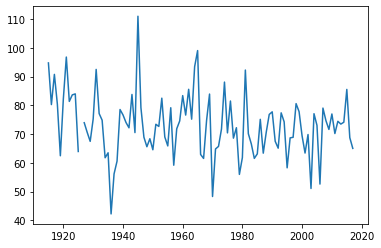

In [56]:
plt.plot(scaled_prec_df.columns[2:], areas)

In [57]:
pd.DataFrame().to_csv('../output/Year_Areas_difference_fixed.csv', index=False)

In [16]:
pd.DataFrame(areas_df).to_excel('../output/Year_Areas_EXPERIMENT.xlsx', index=False)